In [1]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import RobustScaler,StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import importlib
from sklearn.decomposition import PCA

path_src = os.path.abspath('../../../src')

# Agregar esa ruta al sys.path si no está ya
if path_src not in sys.path:
    sys.path.append(path_src)

# Importar utils normalmente
import utils
importlib.reload(utils)

# Importar funciones específicas
from utils import (
    run_agglomerative_mlflow,
    transform_pca,
    silhouette_analysis_agglomerative,
    elbow_method_agglomerative,
    plot_davies_bouldin_scores_agglomerative,
    evaluar_calinski_harabasz_agglomerative
)


In [2]:
rfm_productos_extranjeros = pd.read_csv('../../../dataset/rfm_productos_extranjeros.csv')



print(rfm_productos_extranjeros.columns)

print("cantidad de columnas: ", len(rfm_productos_extranjeros.columns))

print("cantidad de filas: ", len(rfm_productos_extranjeros))



Index(['id_producto', 'Recency', 'Frequency', 'Monetary', 'n_paises_distintos',
       'horario_promedio', '2010-12', '2011-01', '2011-02', '2011-03',
       '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09',
       '2011-10', '2011-11', '2011-12', 'Australia', 'Austria', 'Bahrain',
       'Belgium', 'Brazil', 'Canada', 'Channel Islands', 'Cyprus',
       'Czech Republic', 'Denmark', 'EIRE', 'European Community', 'Finland',
       'France', 'Germany', 'Greece', 'Iceland', 'Israel', 'Italy', 'Japan',
       'Lebanon', 'Lithuania', 'Malta', 'Netherlands', 'Norway', 'Poland',
       'Portugal', 'RSA', 'Saudi Arabia', 'Singapore', 'Spain', 'Sweden',
       'Switzerland', 'USA', 'United Arab Emirates', 'Unspecified'],
      dtype='object')
cantidad de columnas:  55
cantidad de filas:  2781


In [3]:
rfm_productos_extranjeros.head()

,id_producto,Recency,Frequency,Monetary,n_paises_distintos,horario_promedio,2010-12,2011-01,2011-02,2011-03,...,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,Unspecified
0,10002,253,422,358.7,6,11,108.0,193.0,1.0,0.0,...,0.0,0.0,0.0,0.0,24.0,0.0,12.0,0.0,0.0,0.0
1,10120,36,10,2.1,1,13,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10125,1,610,492.7,3,12,0.0,60.0,0.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0
3,10133,114,130,67.5,5,12,20.0,0.0,10.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
4,10135,10,300,287.2,5,10,0.0,0.0,200.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Limpieza de outliers usando el método IQR para Recency, Frequency y Monetary
def remove_outliers_iqr(df, columns):
    """
    Elimina outliers usando el método IQR (Interquartile Range)
    """
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtramos los outliers
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

# Columnas a limpiar
columns_to_clean = ['Recency', 'Frequency', 'Monetary']

# Mostrar estadísticas antes de la limpieza
print("Estadísticas ANTES de la limpieza de outliers:")
print(rfm_productos_extranjeros[columns_to_clean].describe())
print(f"\nCantidad de registros antes: {len(rfm_productos_extranjeros)}")

# Aplicar limpieza de outliers
rfm_productos_extranjeros_clean = remove_outliers_iqr(rfm_productos_extranjeros, columns_to_clean)




Estadísticas ANTES de la limpieza de outliers:
           Recency     Frequency      Monetary
count  2781.000000   2781.000000   2781.000000
mean     69.030924    326.311399    537.350708
std      92.414427    760.944895   1347.455107
min       1.000000      1.000000      0.190000
25%       6.000000     24.000000     40.680000
50%      25.000000     91.000000    148.500000
75%      81.000000    323.000000    525.000000
max     374.000000  15437.000000  31551.750000

Cantidad de registros antes: 2781


In [5]:
id_producto= rfm_productos_extranjeros_clean['id_producto'].copy()

id_producto.head()

1    10120
2    10125
3    10133
4    10135
5    11001
Name: id_producto, dtype: object

In [6]:
rfm_productos_extranjeros_clean.drop(columns=['id_producto','n_paises_distintos'], inplace=True)

In [7]:
rfm_productos_extranjeros_clean

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,...,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,Unspecified
1,36,10,2.10,13,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,610,492.70,12,0.0,60.0,0.0,40.0,20.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0
3,114,130,67.50,12,20.0,0.0,10.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
4,10,300,287.20,10,0.0,0.0,200.0,60.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,15,144,243.36,13,16.0,16.0,0.0,0.0,0.0,0.0,...,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,78,4,6.60,14,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2777,78,4,6.60,14,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2778,78,6,15.30,14,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2779,78,6,12.60,14,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Agglomerative

reduccion de dimensionalidad

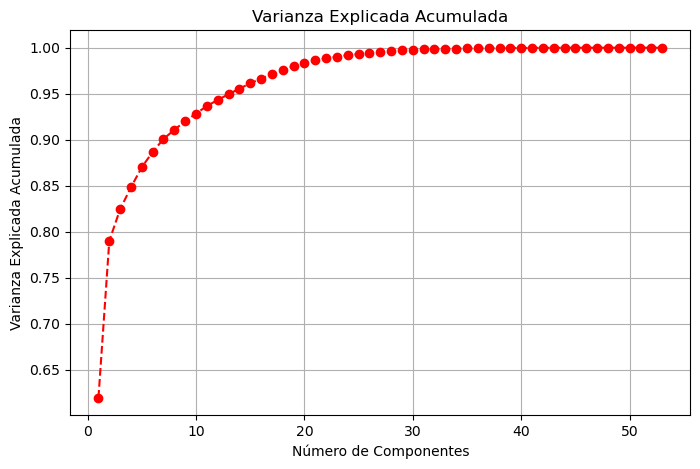

In [8]:
pca=PCA()

pca.fit(rfm_productos_extranjeros_clean)

var_exp=pca.explained_variance_ratio_

# Graficar varianza acumulada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var_exp)+1), var_exp.cumsum(), marker='o', linestyle='--', color='red')
plt.ylabel('Varianza Explicada Acumulada')
plt.xlabel('Número de Componentes')
plt.title('Varianza Explicada Acumulada')
plt.grid()
plt.show()


In [9]:
# Calcular las componentes principales (2 componentes)
componentes = transform_pca(rfm_productos_extranjeros_clean, 2)

dataframe_pca = pd.DataFrame(componentes, columns=['PC1', 'PC2'],index=rfm_productos_extranjeros_clean.index)

dataframe_pca.head()



,PC1,PC2
1,-0.243662,-0.172136
2,0.780048,0.122333
3,-0.246866,0.313773
4,0.301849,-0.004301
5,0.087542,-0.134637


Para n_clusters = 2, el silhouette promedio es: 0.5089
Para n_clusters = 3, el silhouette promedio es: 0.4616
Para n_clusters = 4, el silhouette promedio es: 0.3867
Para n_clusters = 5, el silhouette promedio es: 0.3461
Para n_clusters = 6, el silhouette promedio es: 0.3626
Para n_clusters = 7, el silhouette promedio es: 0.3748
Para n_clusters = 8, el silhouette promedio es: 0.3789
Para n_clusters = 9, el silhouette promedio es: 0.3809
Para n_clusters = 10, el silhouette promedio es: 0.3852
Para n_clusters = 11, el silhouette promedio es: 0.3865
Para n_clusters = 12, el silhouette promedio es: 0.3718
Para n_clusters = 13, el silhouette promedio es: 0.3561
Para n_clusters = 14, el silhouette promedio es: 0.3636


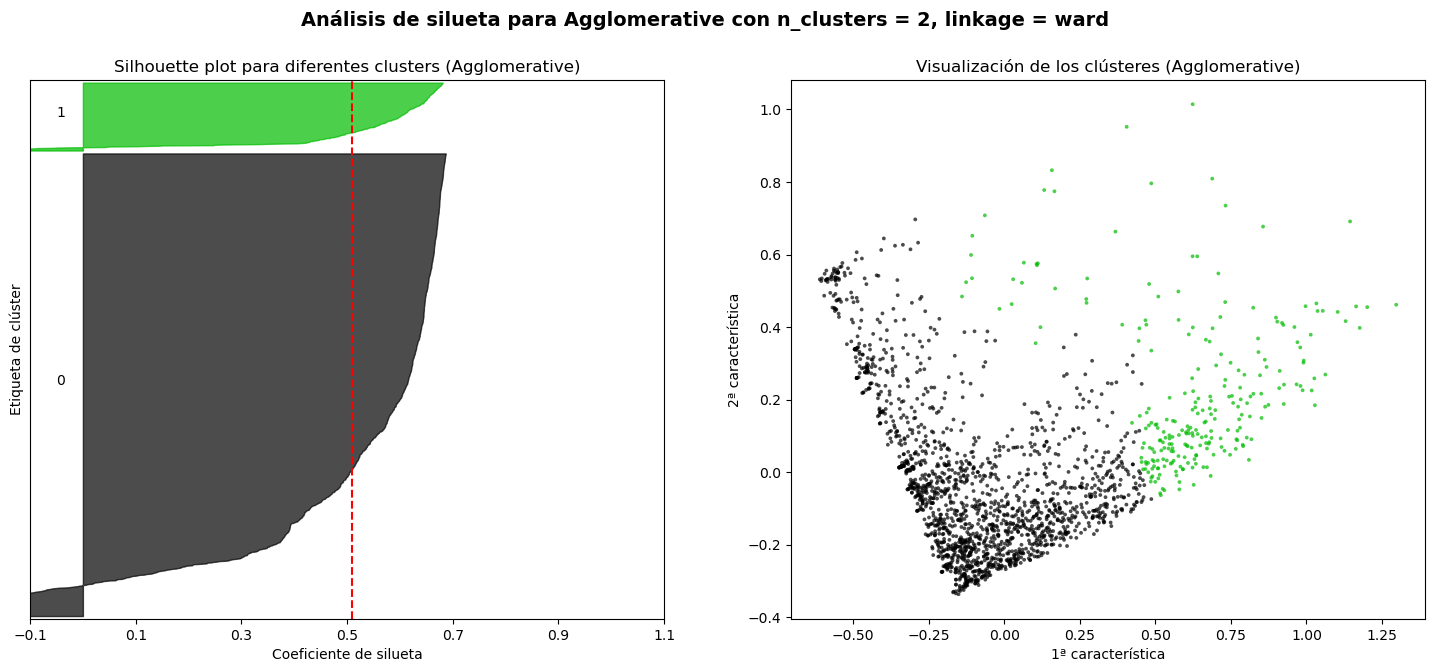

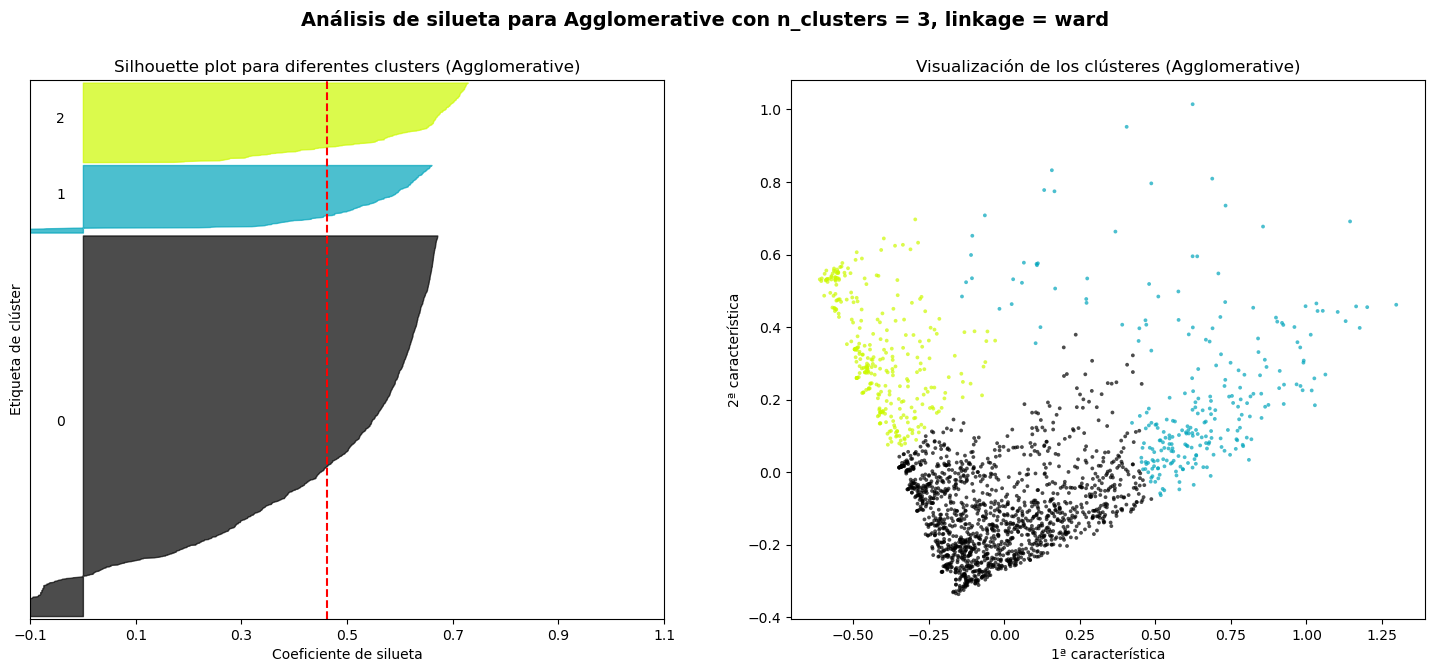

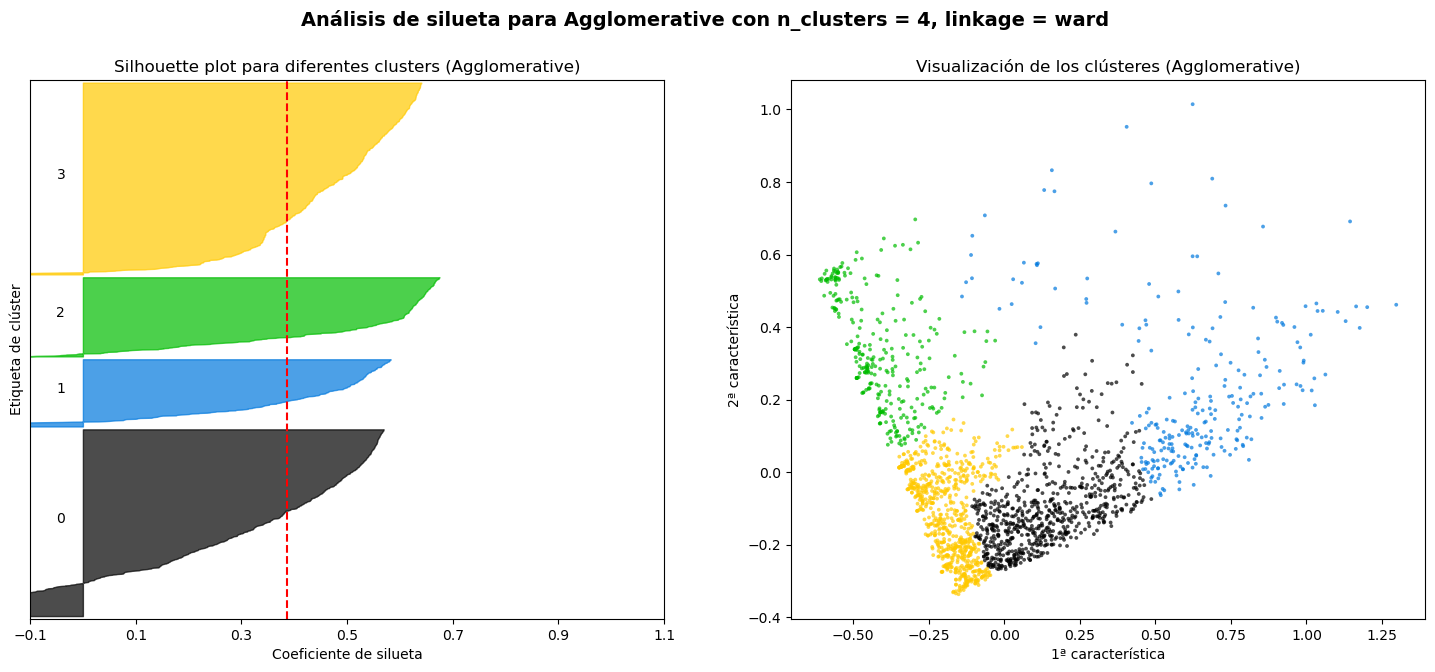

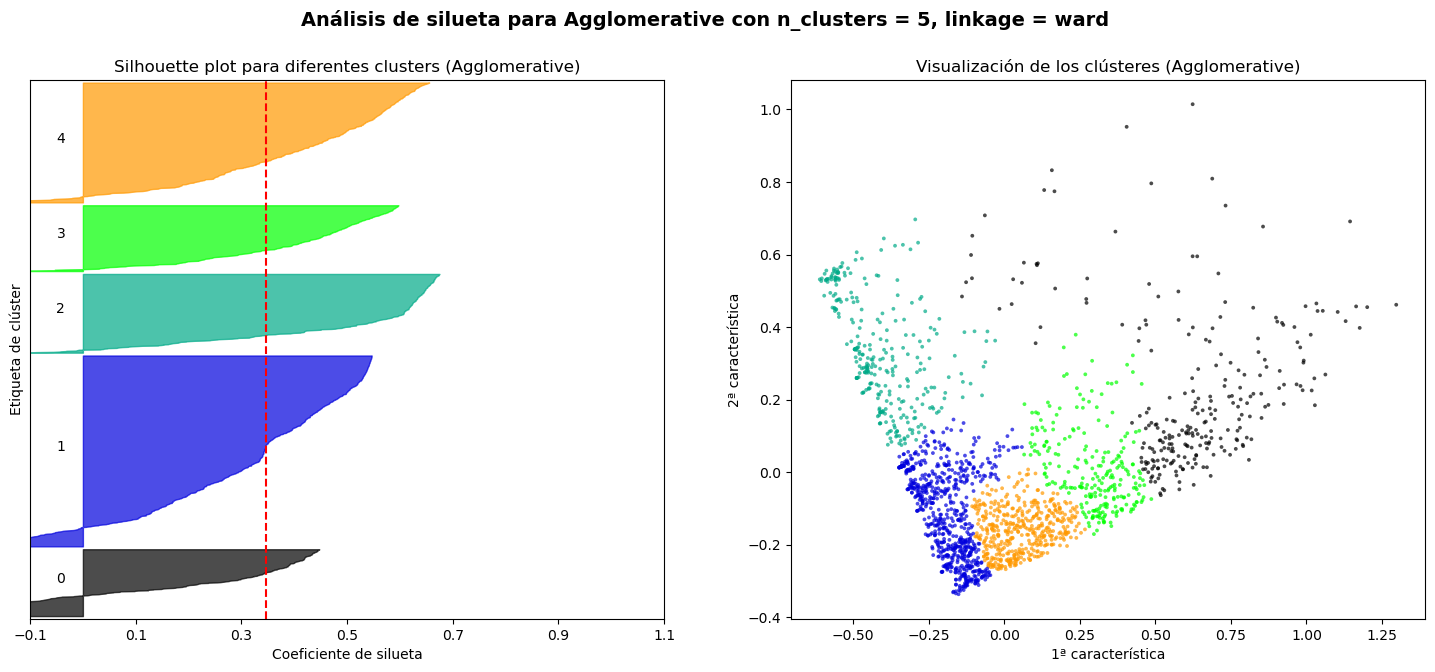

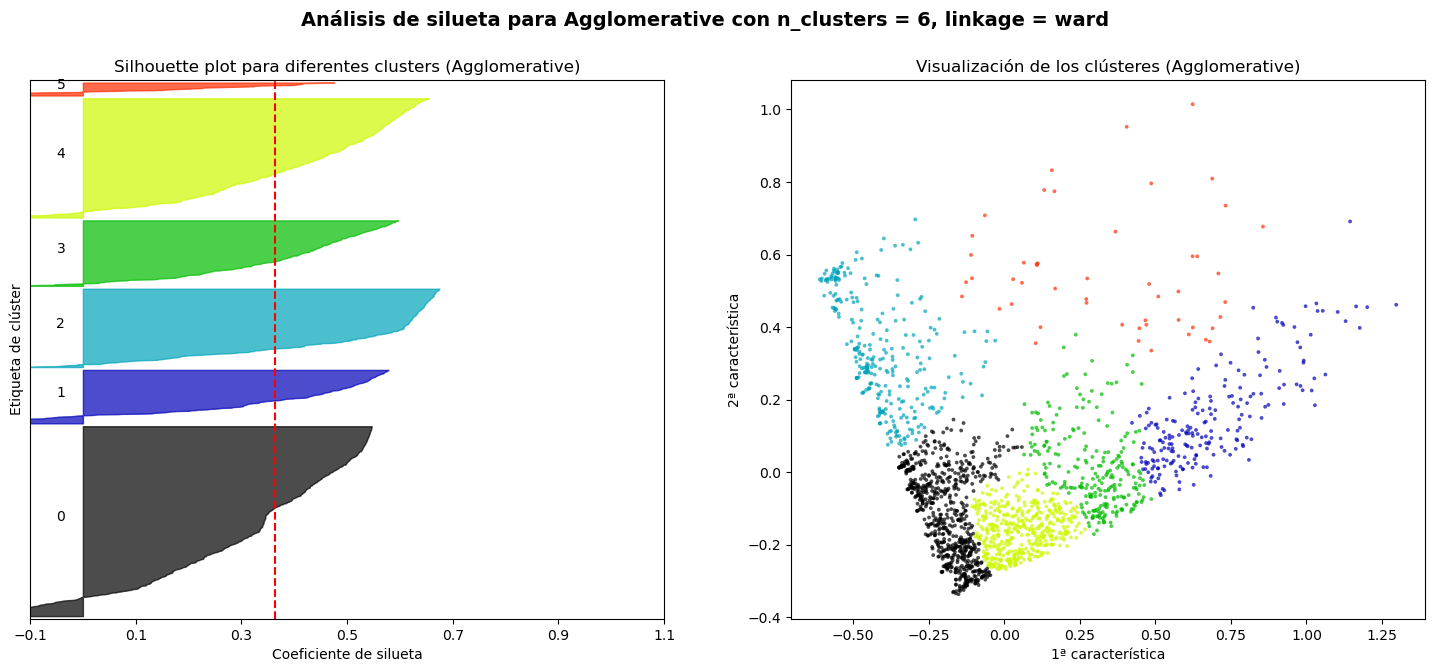

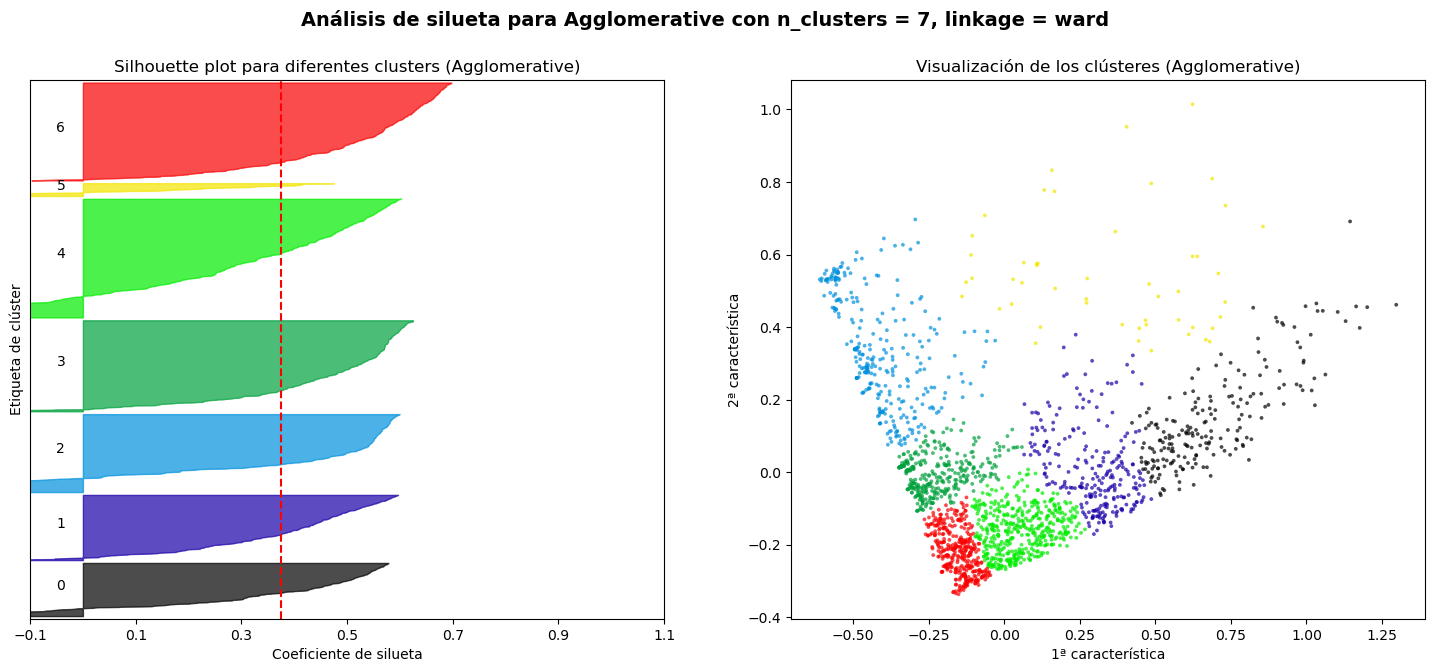

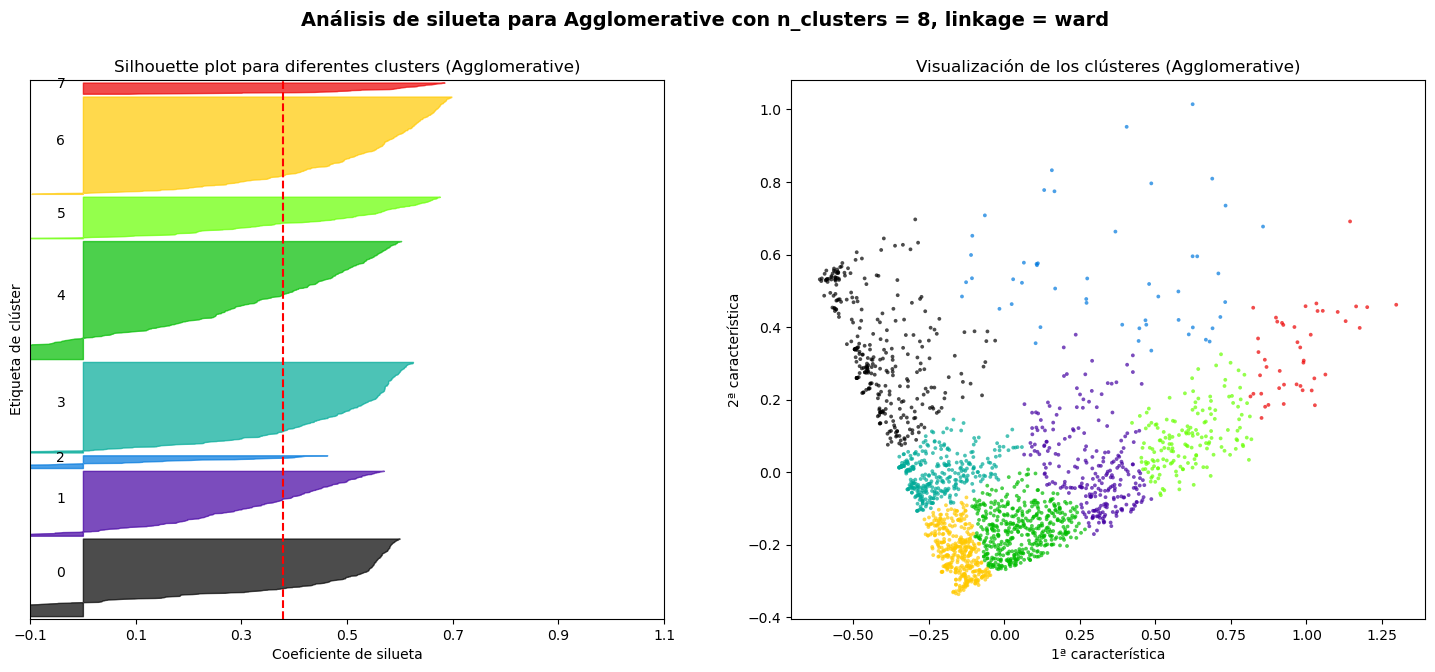

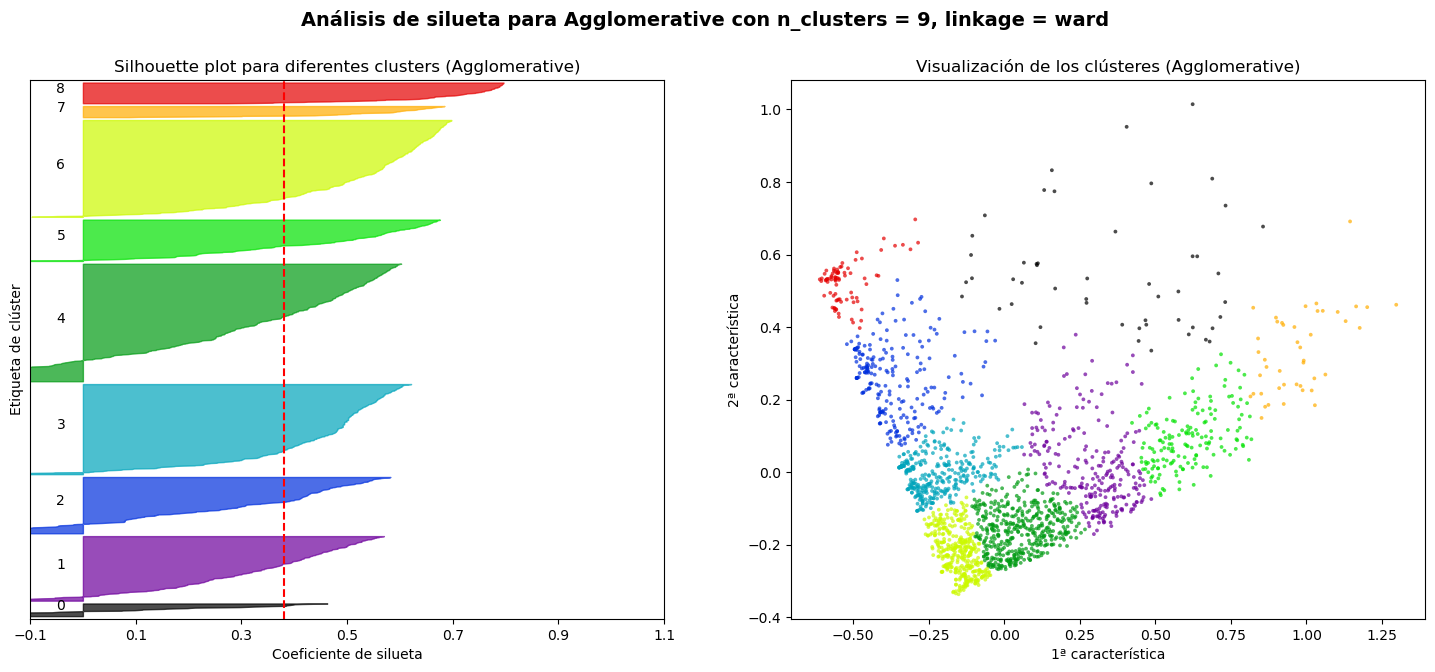

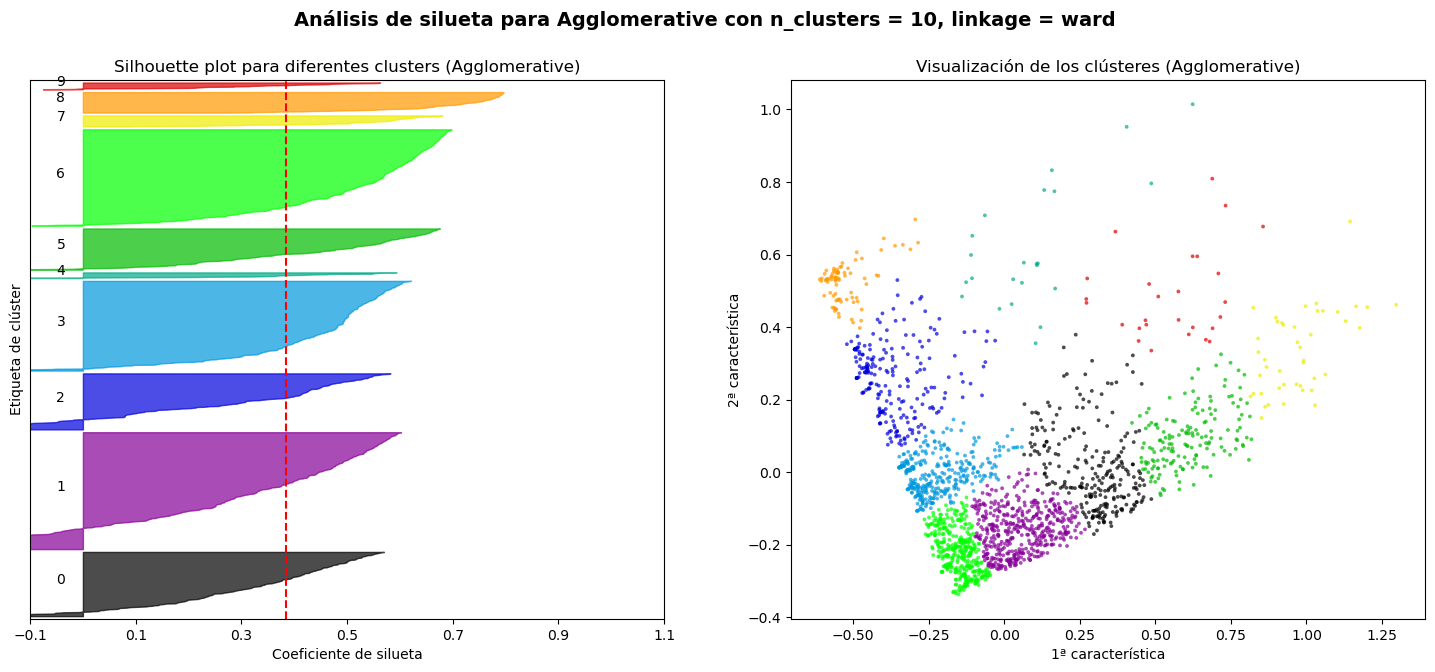

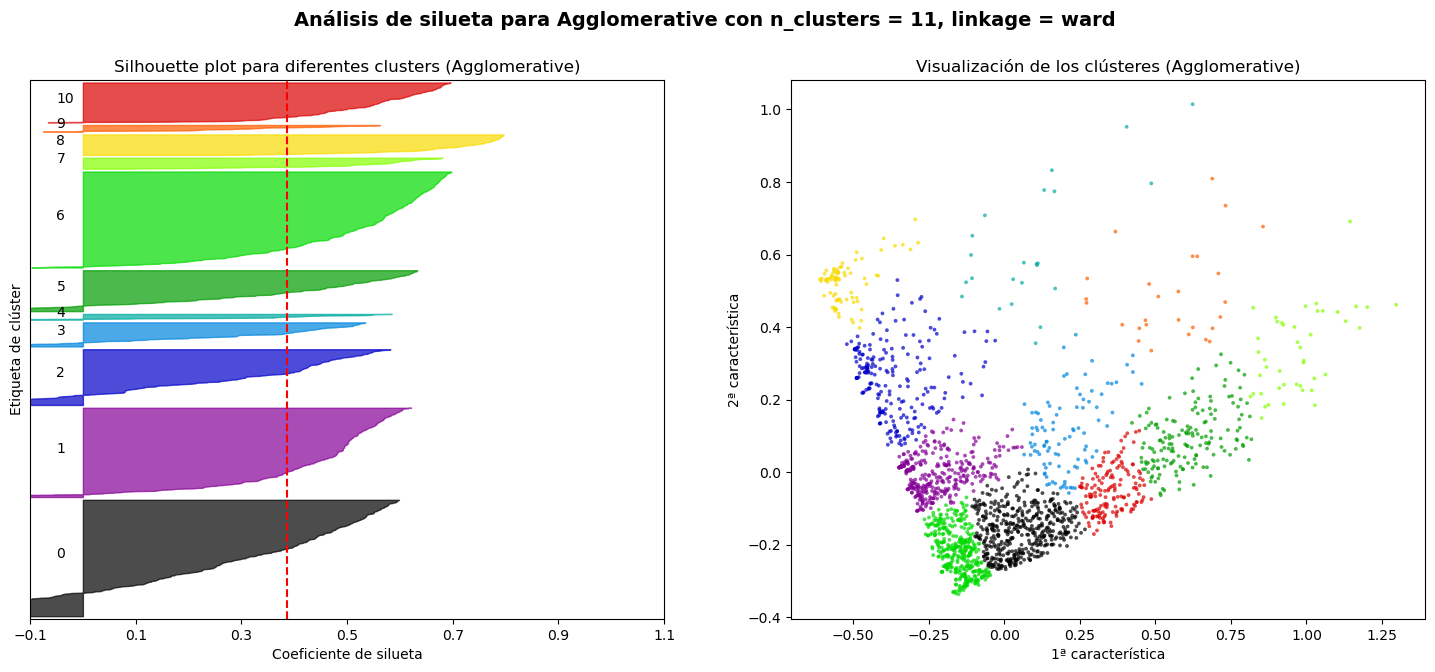

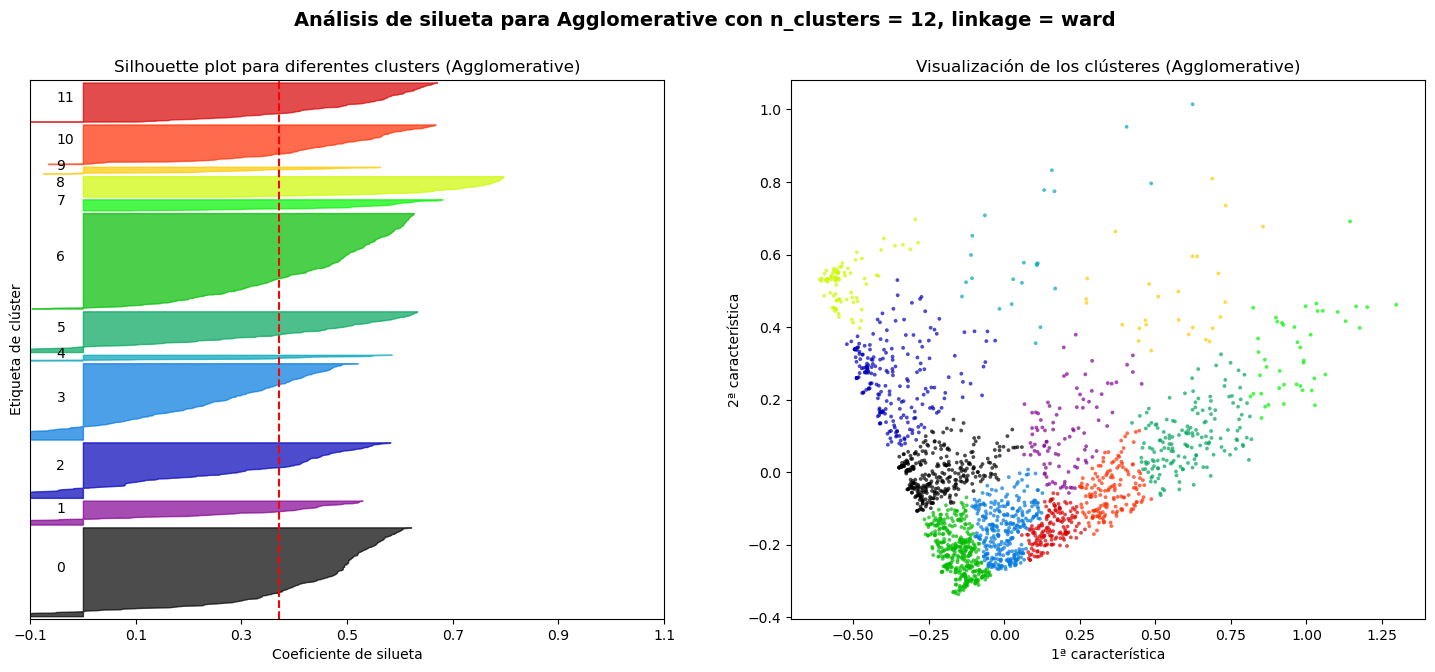

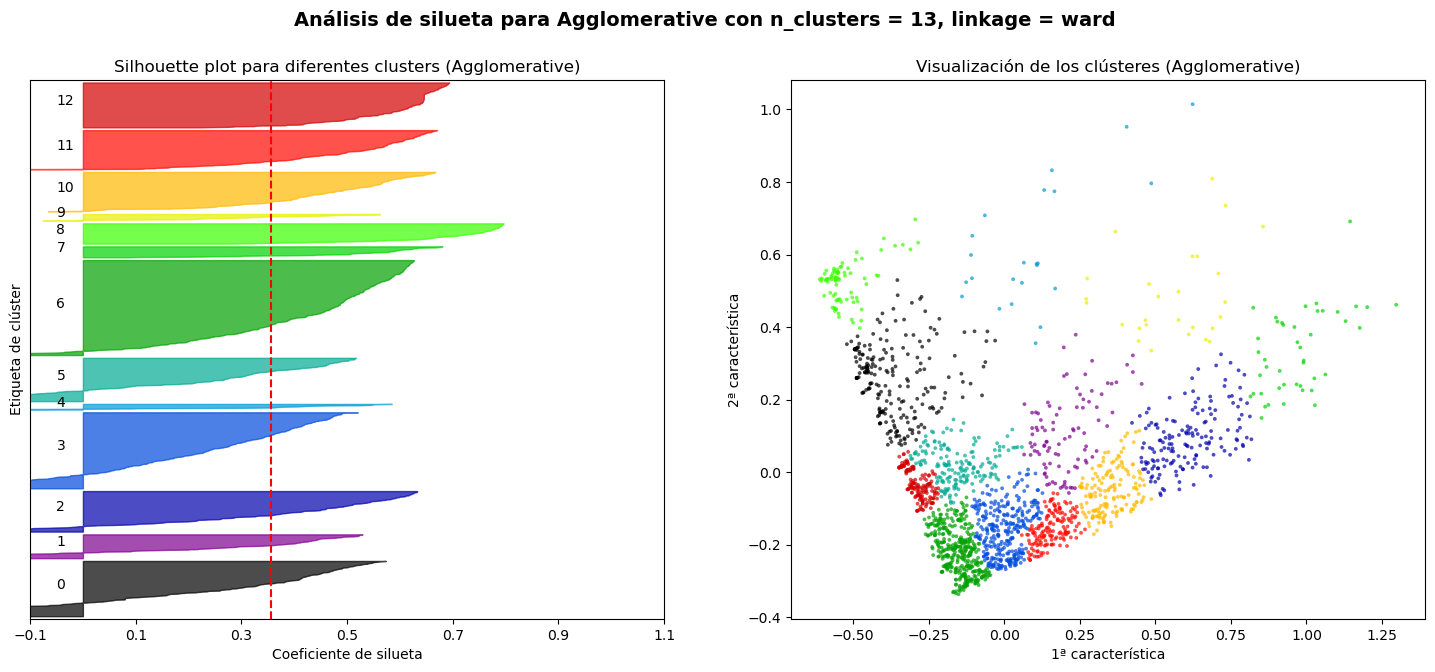

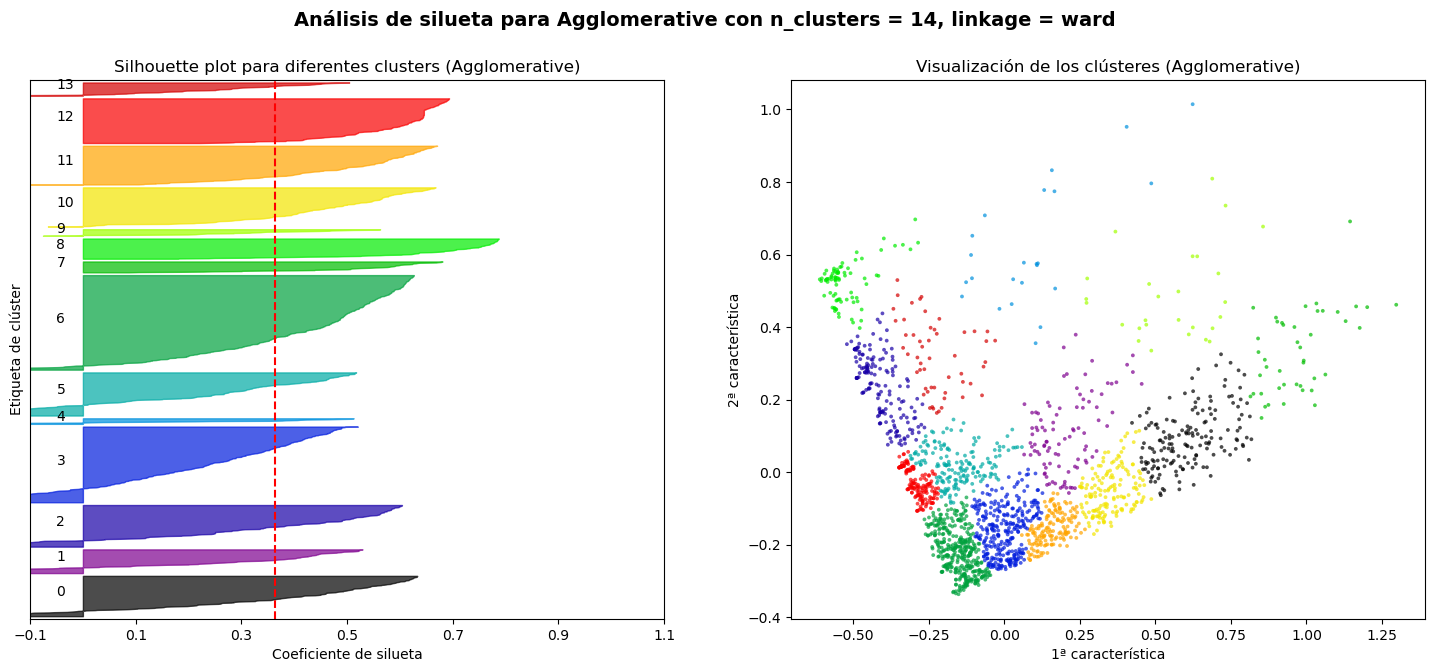

In [10]:
average_silhouette=silhouette_analysis_agglomerative(dataframe_pca.values, range(2, 15))

average_cluster=pd.DataFrame({'n_clusters':range(2,15),'average_silhouette':average_silhouette})

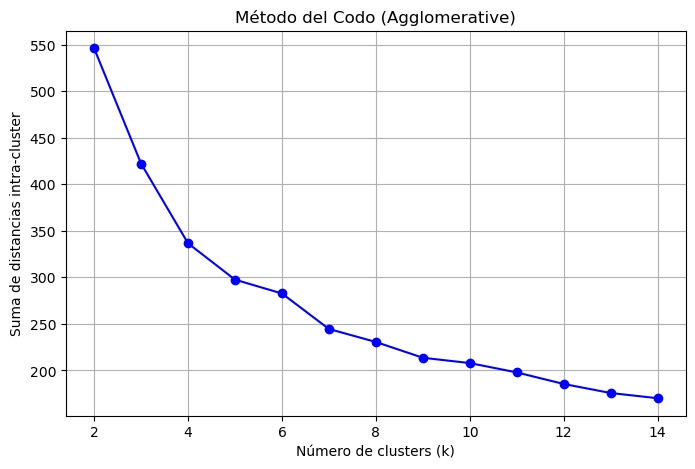

In [11]:
inertias=elbow_method_agglomerative(dataframe_pca.values, range(2, 15))

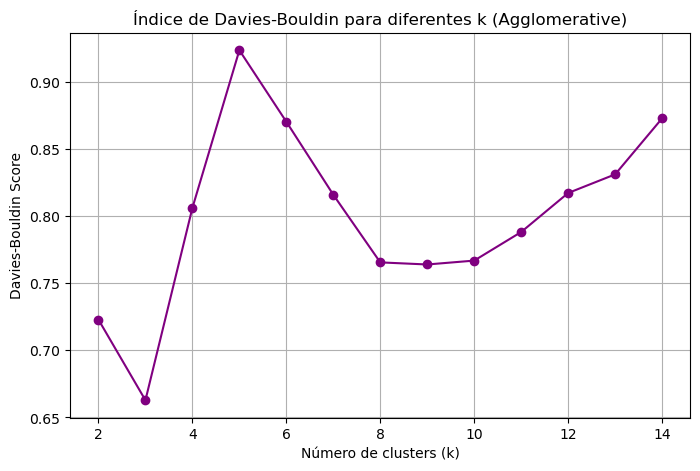

{2: np.float64(0.722896808202587), 3: np.float64(0.6628672059535727), 4: np.float64(0.8061082938384521), 5: np.float64(0.923579023229711), 6: np.float64(0.8703105692264197), 7: np.float64(0.8159250414432812), 8: np.float64(0.7655389742124157), 9: np.float64(0.763978837233274), 10: np.float64(0.7668731699888802), 11: np.float64(0.7881664283453277), 12: np.float64(0.8172297726995174), 13: np.float64(0.8311012334622011), 14: np.float64(0.8728127066978256)}


In [12]:
db_scores=plot_davies_bouldin_scores_agglomerative(dataframe_pca.values, range(2, 15))

print(db_scores)

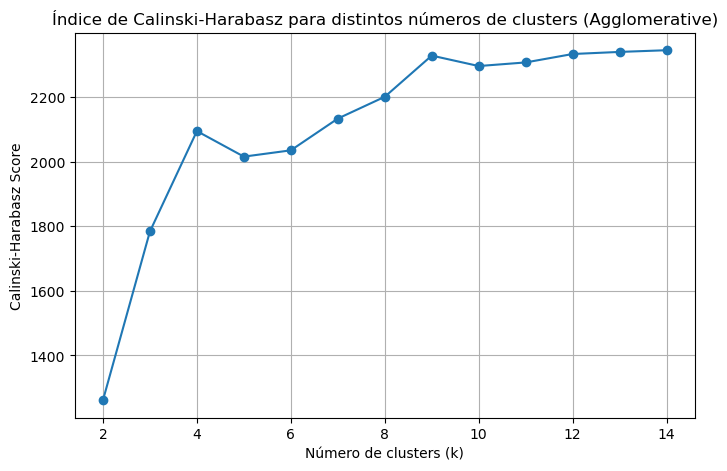

[np.float64(1261.5542033506135), np.float64(1783.8418144003922), np.float64(2094.4275551659775), np.float64(2015.39108115272), np.float64(2034.8926147664115), np.float64(2133.118388695465), np.float64(2200.617111945264), np.float64(2328.025557897843), np.float64(2295.7312814246256), np.float64(2306.889008821111), np.float64(2332.9739731232917), np.float64(2339.4389241236872), np.float64(2344.6810950679514)]


In [13]:
ch_scores=evaluar_calinski_harabasz_agglomerative(dataframe_pca.values, range(2, 15))

print(ch_scores)

2025/07/14 00:06:33 INFO mlflow.tracking.fluent: Experiment with name 'AGGLOMERATIVE-PRODUCTOS_EXTRANJEROS' does not exist. Creating a new experiment.


Run ID final clustering: a86c1cf524ac4eaa8f0a0dbe2c609bf0
🏃 View run Final_Clustering_agglomerative_k=3 at: http://localhost:5000/#/experiments/525198871624055159/runs/a86c1cf524ac4eaa8f0a0dbe2c609bf0
🧪 View experiment at: http://localhost:5000/#/experiments/525198871624055159


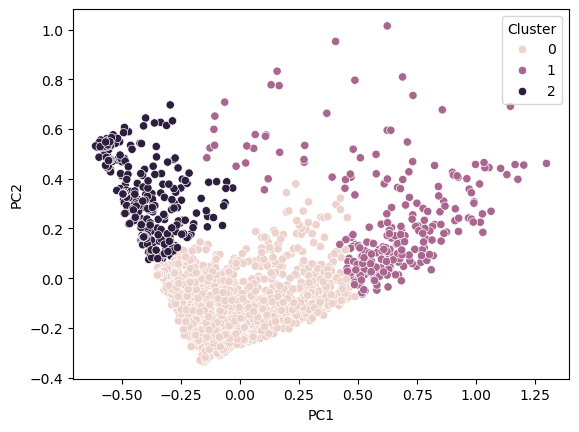

In [14]:
data_pca_cluster=run_agglomerative_mlflow(dataframe_pca, 3, 'ward', 'AGGLOMERATIVE-PRODUCTOS_EXTRANJEROS')

sns.scatterplot(data=data_pca_cluster,x='PC1',y='PC2',hue='Cluster')
plt.show()

In [15]:
data_pca_cluster

,PC1,PC2,Cluster
1,-0.243662,-0.172136,0
2,0.780048,0.122333,1
3,-0.246866,0.313773,2
4,0.301849,-0.004301,0
5,0.087542,-0.134637,0
...,...,...,...
2776,-0.346328,0.012963,0
2777,-0.346328,0.012963,0
2778,-0.338953,0.015822,0
2779,-0.340530,0.015295,0


In [16]:
id_producto.index = data_pca_cluster.index

In [17]:
data_pca_cluster['id_producto'] = id_producto

In [18]:
data_pca_cluster = data_pca_cluster[['id_producto', 'PC1', 'PC2', 'Cluster']]

In [19]:
data_pca_cluster

,id_producto,PC1,PC2,Cluster
1,10120,-0.243662,-0.172136,0
2,10125,0.780048,0.122333,1
3,10133,-0.246866,0.313773,2
4,10135,0.301849,-0.004301,0
5,11001,0.087542,-0.134637,0
...,...,...,...,...
2776,90205A,-0.346328,0.012963,0
2777,90205C,-0.346328,0.012963,0
2778,90208,-0.338953,0.015822,0
2779,90209A,-0.340530,0.015295,0


In [20]:
rfm_productos_extranjeros_clean['Cluster']=data_pca_cluster['Cluster']
rfm_productos_extranjeros_clean['id_producto']=id_producto




In [21]:
rfm_productos_extranjeros_clean.head()

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,...,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,Unspecified,Cluster,id_producto
1,36,10,2.10,13,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,10120
2,1,610,492.70,12,0.0,60.0,0.0,40.0,20.0,100.0,...,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,1,10125
3,114,130,67.50,12,20.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,2,10133
4,10,300,287.20,10,0.0,0.0,200.0,60.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,10135
5,15,144,243.36,13,16.0,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0,11001


In [22]:
rfm_productos_extranjeros_clean.columns

Index(['Recency', 'Frequency', 'Monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       'Australia', 'Austria', 'Bahrain', 'Belgium', 'Brazil', 'Canada',
       'Channel Islands', 'Cyprus', 'Czech Republic', 'Denmark', 'EIRE',
       'European Community', 'Finland', 'France', 'Germany', 'Greece',
       'Iceland', 'Israel', 'Italy', 'Japan', 'Lebanon', 'Lithuania', 'Malta',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'RSA', 'Saudi Arabia',
       'Singapore', 'Spain', 'Sweden', 'Switzerland', 'USA',
       'United Arab Emirates', 'Unspecified', 'Cluster', 'id_producto'],
      dtype='object')

In [23]:
cluster_summary = rfm_productos_extranjeros_clean.groupby('Cluster').mean(numeric_only=True)
display(cluster_summary)

,Recency,Frequency,Monetary,horario_promedio,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,...,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,Unspecified
Cluster,,,,,,,,,,,,,,,,,,,,,
0,29.173064,104.746685,178.716504,12.274250,5.133287,5.981856,4.242847,5.381019,2.889044,6.193301,...,2.744592,0.045359,0.008374,1.079553,4.999302,1.129100,4.892533,0.297278,0.143754,0.351012
1,29.356863,494.921569,581.108314,12.078431,28.733333,39.450980,27.043137,36.172549,21.007843,38.047059,...,9.176471,0.109804,0.023529,6.250980,16.203922,16.454902,21.909804,2.196078,0.756863,1.376471
2,136.266667,41.723333,64.383433,11.943333,2.216667,4.413333,1.690000,4.050000,2.036667,3.753333,...,0.896667,0.000000,0.000000,0.826667,1.886667,0.133333,1.536667,0.016667,0.280000,0.553333


In [24]:
cluster_summary.columns


Index(['Recency', 'Frequency', 'Monetary', 'horario_promedio', '2010-12',
       '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       'Australia', 'Austria', 'Bahrain', 'Belgium', 'Brazil', 'Canada',
       'Channel Islands', 'Cyprus', 'Czech Republic', 'Denmark', 'EIRE',
       'European Community', 'Finland', 'France', 'Germany', 'Greece',
       'Iceland', 'Israel', 'Italy', 'Japan', 'Lebanon', 'Lithuania', 'Malta',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'RSA', 'Saudi Arabia',
       'Singapore', 'Spain', 'Sweden', 'Switzerland', 'USA',
       'United Arab Emirates', 'Unspecified'],
      dtype='object')

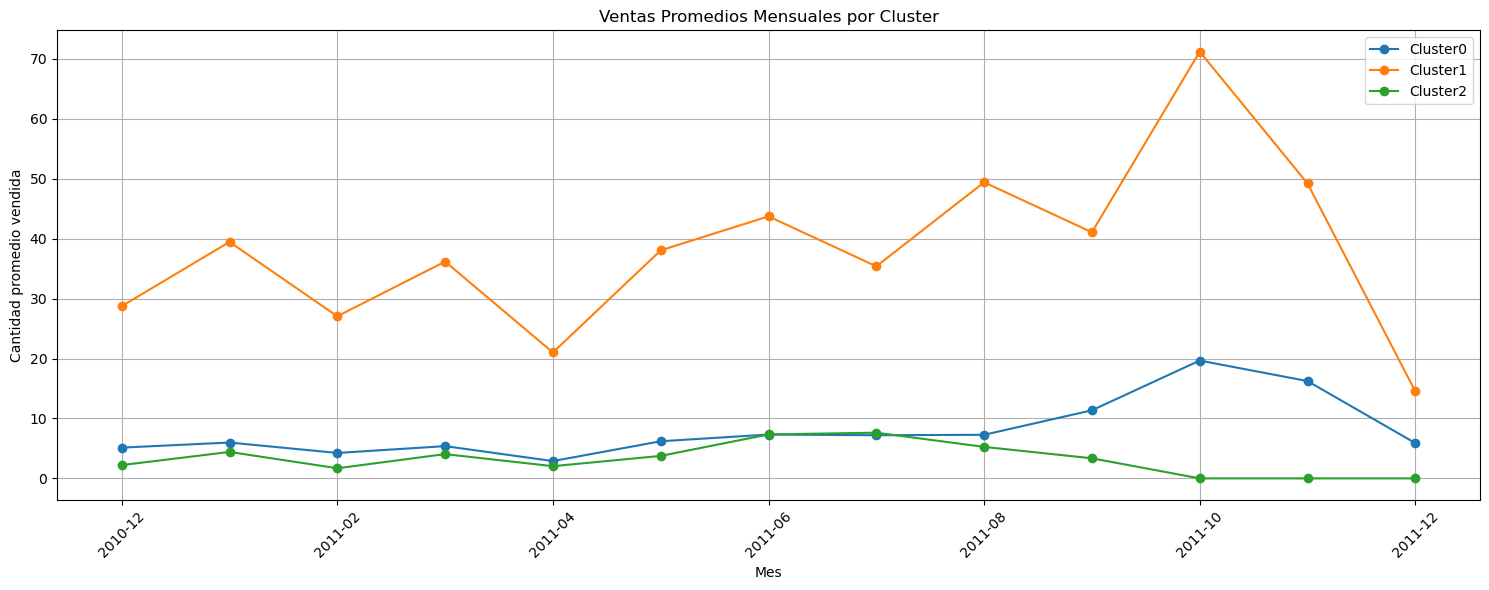

In [25]:
cluster0_mes= cluster_summary.iloc[0].T
cluster1_mes= cluster_summary.iloc[1].T
cluster2_mes= cluster_summary.iloc[2].T

columnas_fechas = [col for col in rfm_productos_extranjeros_clean.columns if col.startswith('201')]

cluster0_mes=cluster0_mes[columnas_fechas]
cluster1_mes=cluster1_mes[columnas_fechas]
cluster2_mes=cluster2_mes[columnas_fechas]

ventas_promedios_mensuales=pd.concat([cluster0_mes,cluster1_mes,cluster2_mes],axis=1)
ventas_promedios_mensuales.columns=['Cluster0','Cluster1','Cluster2']

ventas_promedios_mensuales.plot(
    figsize=(15, 6),
    title='Ventas Promedios Mensuales por Cluster',
    marker='o' ,
    markersize=6 )

plt.xlabel("Mes")
plt.ylabel("Cantidad promedio vendida")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



In [33]:
ventas_promedios_mensuales

,Cluster0,Cluster1,Cluster2
2010-12,5.133287,28.733333,2.216667
2011-01,5.981856,39.450980,4.413333
2011-02,4.242847,27.043137,1.690000
2011-03,5.381019,36.172549,4.050000
2011-04,2.889044,21.007843,2.036667
2011-05,6.193301,38.047059,3.753333
2011-06,7.313329,43.717647,7.330000
2011-07,7.198883,35.380392,7.626667
2011-08,7.272854,49.396078,5.253333
2011-09,11.359386,41.066667,3.353333


In [26]:
paises=['Australia', 'Austria', 'Bahrain', 'Belgium', 'Brazil', 'Canada',
       'Channel Islands', 'Cyprus', 'Czech Republic', 'Denmark', 'EIRE',
       'European Community', 'Finland', 'France', 'Germany', 'Greece',
       'Iceland', 'Israel', 'Italy', 'Japan', 'Lebanon', 'Lithuania', 'Malta',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'RSA', 'Saudi Arabia',
       'Singapore', 'Spain', 'Sweden', 'Switzerland', 'USA',
       'United Arab Emirates', 'Unspecified']


cantidad_de_paises=len(paises)
print(cantidad_de_paises)

cluester0_paises=cluster_summary.iloc[0].T
cluester1_paises=cluster_summary.iloc[1].T
cluester2_paises=cluster_summary.iloc[2].T

cluester0_paises=cluester0_paises[paises]
cluester1_paises=cluester1_paises[paises]
cluester2_paises=cluester2_paises[paises]

venta_promedio_paises=pd.concat([cluester0_paises,cluester1_paises,cluester2_paises],axis=1)
venta_promedio_paises.columns=['Cluster 0','Cluster 1','Cluster 2']


venta_promedio_paises.head(5)


36


,Cluster 0,Cluster 1,Cluster 2
Australia,5.991626,44.117647,2.363333
Austria,0.810886,2.447059,0.113333
Bahrain,0.032100,0.000000,0.020000
Belgium,2.942080,8.262745,1.376667
Brazil,0.048849,0.023529,0.000000


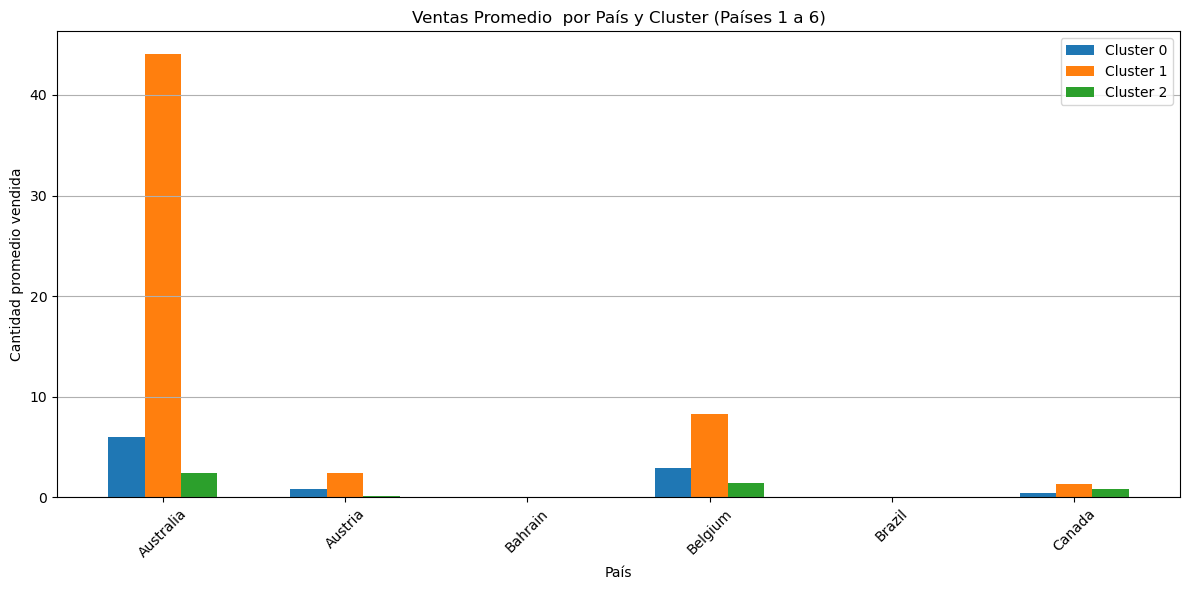

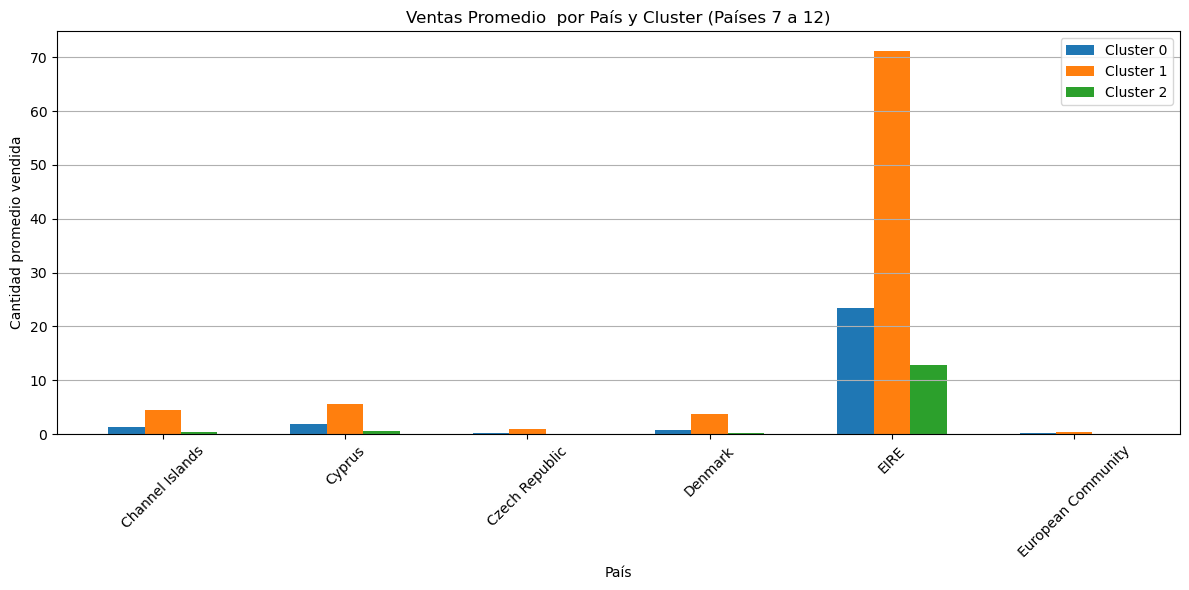

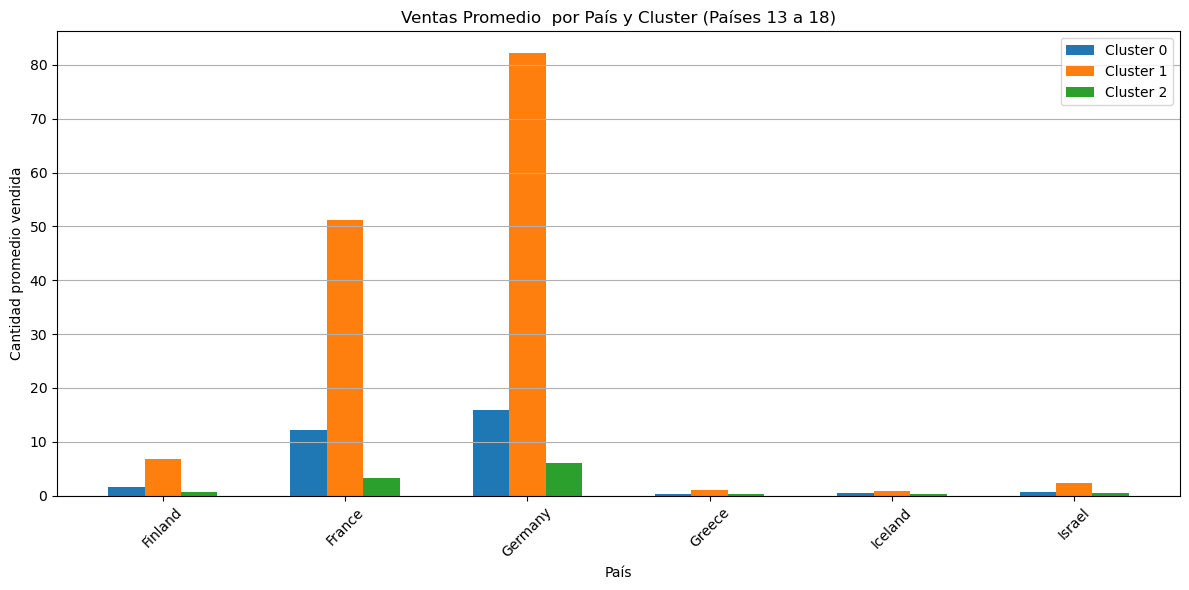

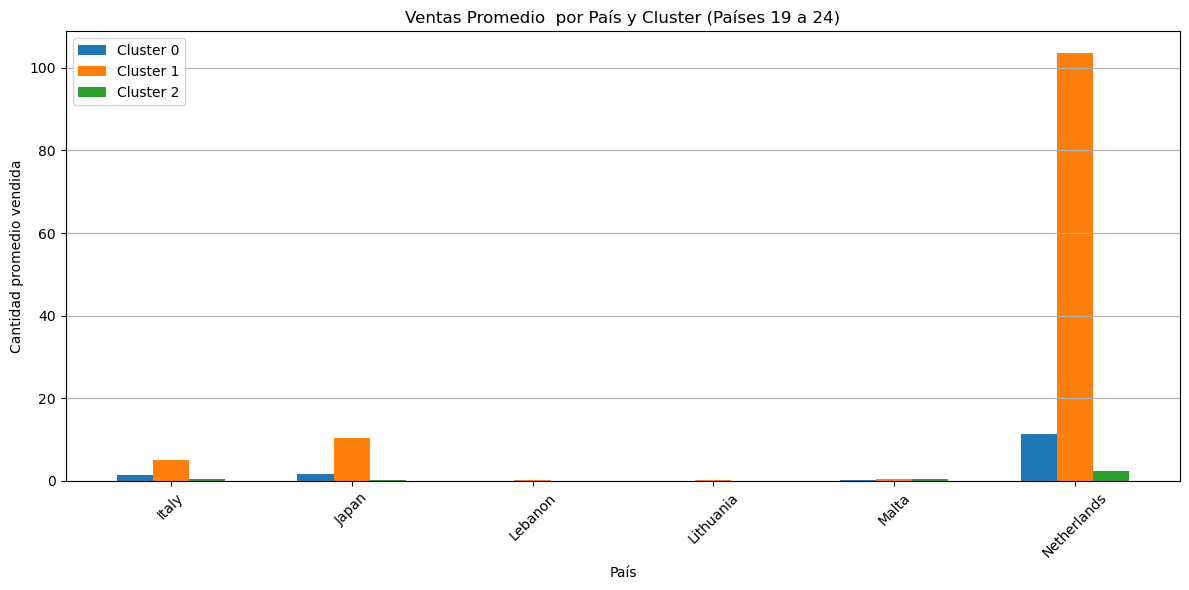

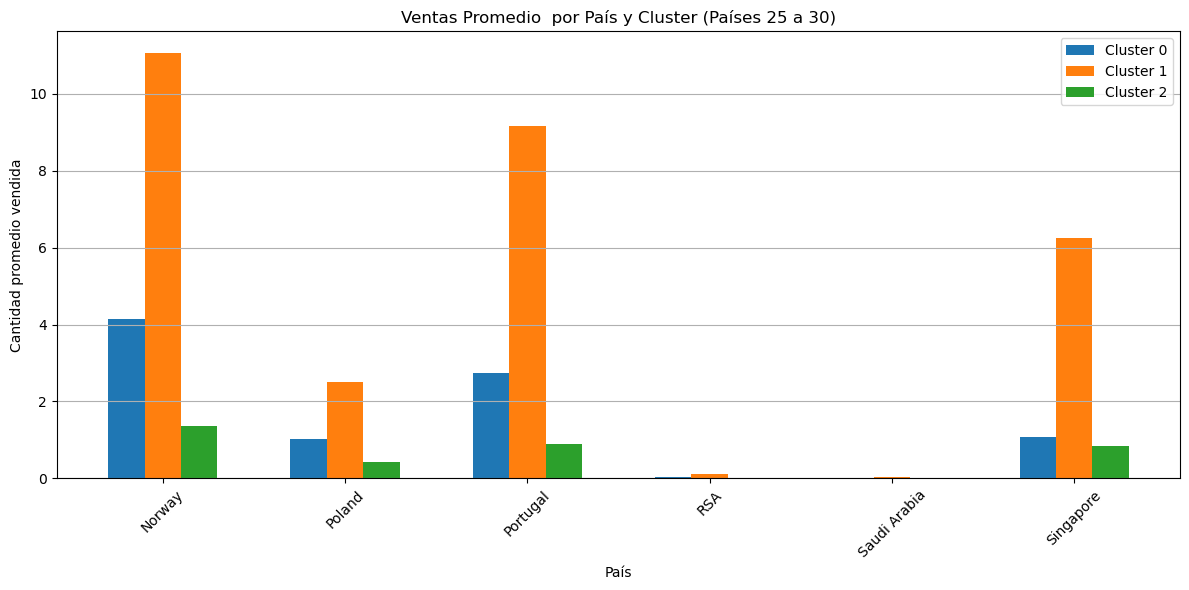

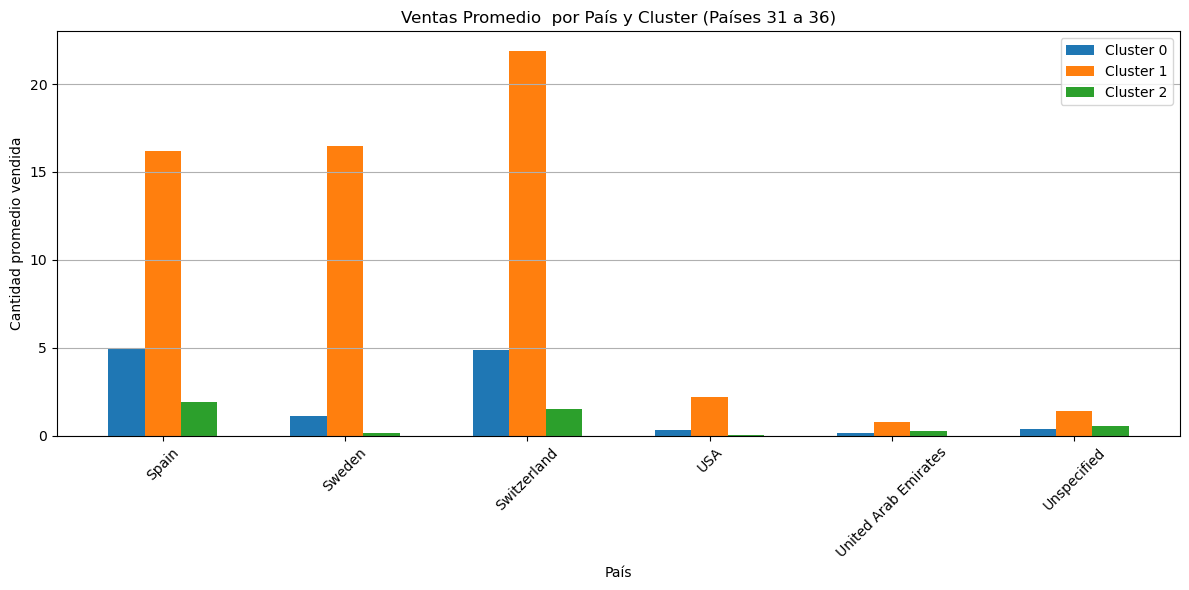

In [27]:

# Subconjunto de países y valores (6 países por lote)
lote = 6
total_paises = venta_promedio_paises.shape[0]
num_graficos = int(np.ceil(total_paises / lote))

for i in range(num_graficos):
    start = i * lote
    end = min(start + lote, total_paises)
    datos_lote = venta_promedio_paises.iloc[start:end]  # DataFrame con filas y 3 columnas

    # Parámetros para barras agrupadas
    n_paises = datos_lote.shape[0]
    n_clusters = datos_lote.shape[1]
    x = np.arange(n_paises)  # posiciones para países en eje X
    width = 0.2  # ancho de cada barra

    plt.figure(figsize=(12,6))
    for j in range(n_clusters):
        plt.bar(x + j*width, datos_lote.iloc[:, j], width=width, label=datos_lote.columns[j])

    plt.title(f'Ventas Promedio  por País y Cluster (Países {start+1} a {end})')
    plt.xlabel('País')
    plt.ylabel('Cantidad promedio vendida')
    plt.xticks(x + width, datos_lote.index, rotation=45)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


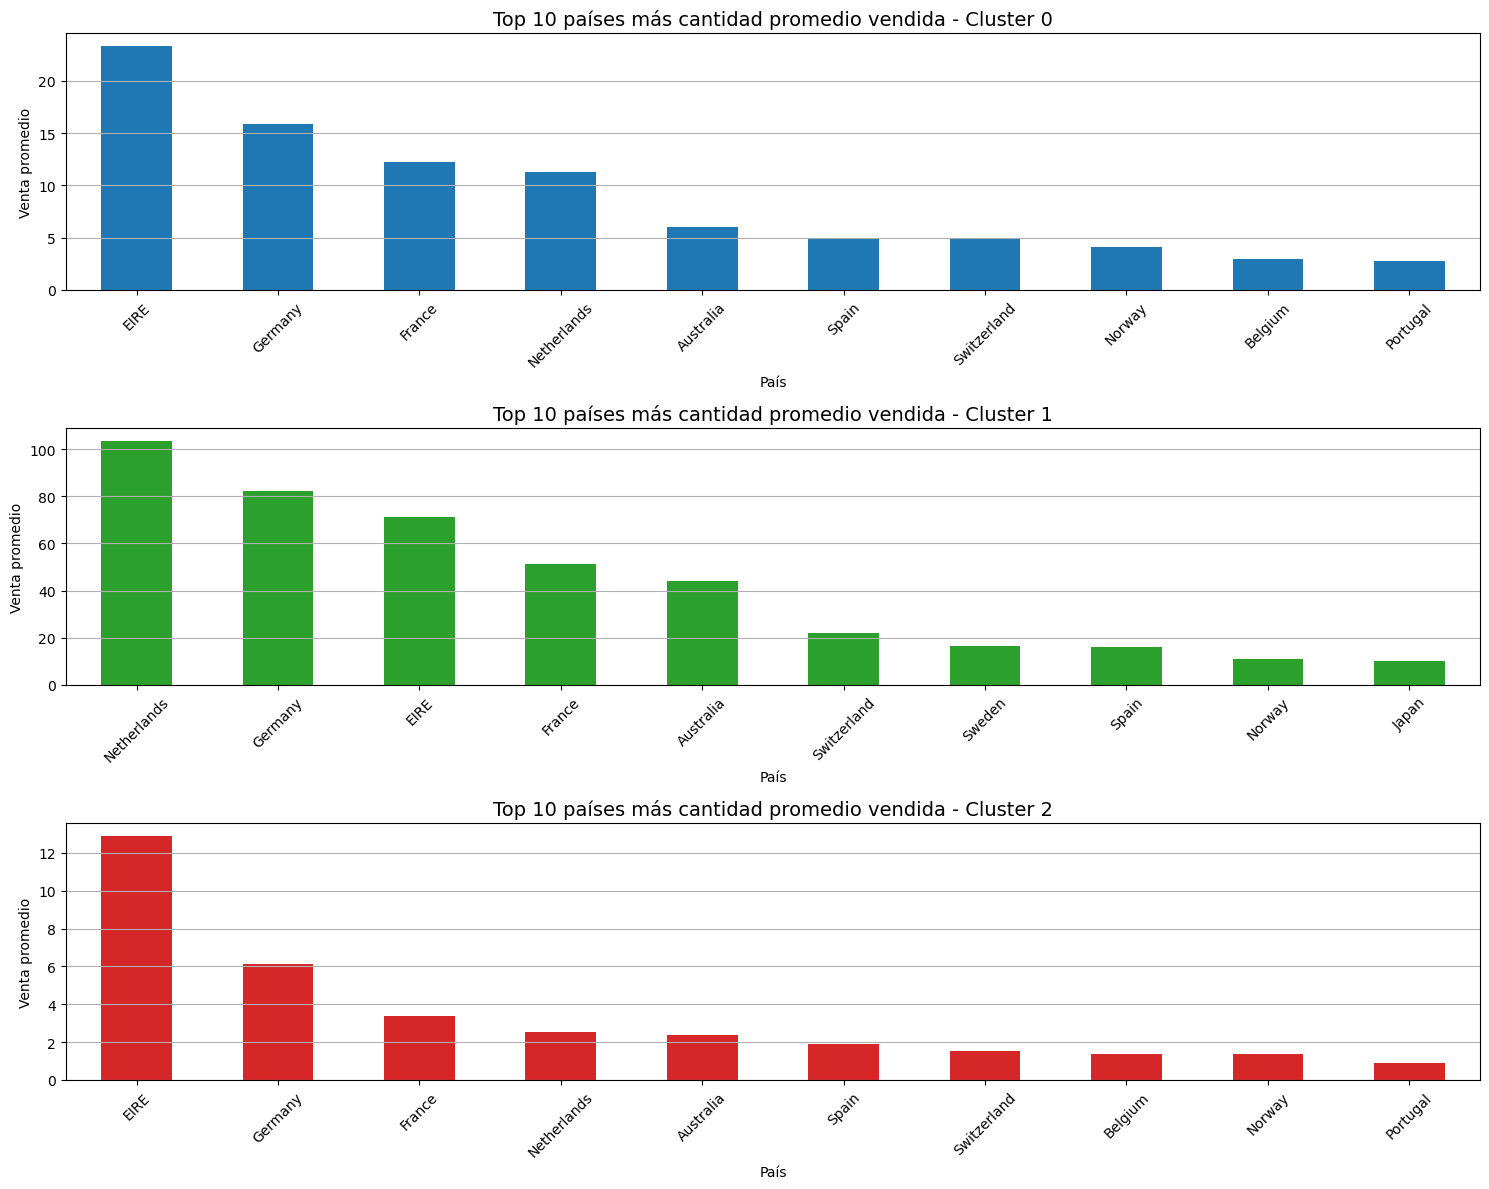

In [28]:


top_mas_vendido_cluster0_pais = venta_promedio_paises.sort_values(by='Cluster 0', ascending=False)['Cluster 0'].head(10)
top_mas_vendido_cluster1_pais = venta_promedio_paises.sort_values(by='Cluster 1', ascending=False)['Cluster 1'].head(10)
top_mas_vendido_cluster2_pais = venta_promedio_paises.sort_values(by='Cluster 2', ascending=False)['Cluster 2'].head(10)

top_10_mas_vendido = [
    top_mas_vendido_cluster0_pais, 
    top_mas_vendido_cluster1_pais, 
    top_mas_vendido_cluster2_pais
]
colors = ['#1f77b4', '#2ca02c', '#d62728']  
fig, axs = plt.subplots(3, 1, figsize=(15, 12))  

for i, cluster_data in enumerate(top_10_mas_vendido):
    cluster_data.plot(kind='bar', ax=axs[i], color=colors[i])
    axs[i].set_title(f'Top 10 países más cantidad promedio vendida - Cluster {i}', fontsize=14)
    axs[i].set_xlabel('País')
    axs[i].set_ylabel('Venta promedio')
    axs[i].set_xticks(range(len(cluster_data)))
    axs[i].set_xticklabels(cluster_data.index, rotation=45)
    axs[i].grid(axis='y')

plt.tight_layout()
plt.show()







In [29]:
rfm_columnas=['Recency', 'Frequency', 'Monetary']
cluster0_rfm=cluster_summary.iloc[0].T
cluster1_rfm=cluster_summary.iloc[1].T
cluster2_rfm=cluster_summary.iloc[2].T

cluster0_rfm=cluster0_rfm[rfm_columnas]
cluster1_rfm=cluster1_rfm[rfm_columnas]
cluster2_rfm=cluster2_rfm[rfm_columnas]

rfm_promedio_cluster=pd.concat([cluster0_rfm,cluster1_rfm,cluster2_rfm],axis=1)
rfm_promedio_cluster.columns=['Cluster 0','Cluster 1','Cluster 2']





In [31]:
rfm_promedio_cluster

,Cluster 0,Cluster 1,Cluster 2
Recency,29.173064,29.356863,136.266667
Frequency,104.746685,494.921569,41.723333
Monetary,178.716504,581.108314,64.383433


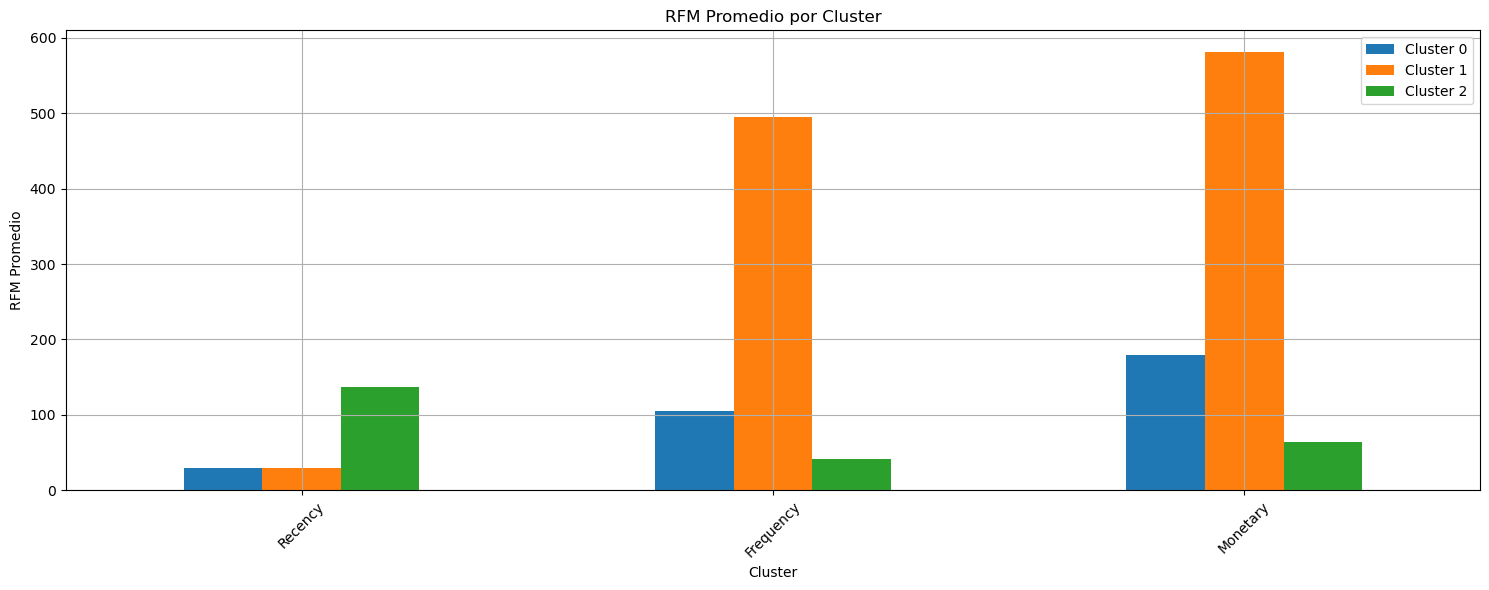

In [30]:
rfm_promedio_cluster.plot(kind='bar', figsize=(15, 6))
plt.title('RFM Promedio por Cluster')
plt.xlabel('Cluster')
plt.ylabel('RFM Promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
agg_productos_extranjeros = rfm_productos_extranjeros_clean[['id_producto','Cluster']]
agg_productos_extranjeros.to_csv('../../../dataset/agg_productos_extranjeros.csv', index=False)